(tensor-network-optimization)=

# Optimization

`quimb` supports optimizing an abtirary tensor network with respect to an arbitrary 'loss' function using automatic differentiation. This is encapsulated in the [`TNOptimizer`](quimb.tensor.optimize.TNOptimizer) object. Internally, this makes use of one of various autodiff libraries to compute the neccesary tensor gradients, then maps these tensor parameters into a 'ravelled' single real vector for optimization in an outer loop by {func}`scipy.optimize.minimize`.

```{note}
You can also use `quimb` simply as a way to orchestrate operations on e.g. `torch` or `jax` arrays, and then use optimiztion libraries from those frameworks directly. This is demonstrated in the examples {ref}`quimb-within-torch` and {ref}`quimb-within-jax`.
```

The basic steps are:

1. Define a **target tensor network** (or pytree[^pytree] of `TensorNetwork`, `Tensor`, raw array, or `Circuit` objects).
2. *Optionally* if its a single tensor network, define sets of tags that specify which tensors to optimize, keep constant, or share parameters among.
3. *Optionally* define a `norm_fn` that takes the target and projects or constrains it to some valid form, e.g. normalizing or mapping into unitary form. This is the identity by default.
4. Define a **loss function** that takes `tn` (or `norm_fn(tn)`) and returns a single real scalar to minimize.

Here we'll demonstrate this with a PBC MPS optimization for the Heisenberg model.

[^pytree]: Any nested combination of `dict`, `list`, and `tuple` objects.

In [3]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

In [4]:
L = 64
D = 16
pbc = True

# create a random MPS as our initial target to optimize
psi = qtn.MPS_rand_state(L, bond_dim=D, cyclic=pbc)

# create the hamiltonian MPO, this is a constant TN not to be optimized
ham = qtn.MPO_ham_heis(L, cyclic=pbc)

Next we define our `norm_fn`, which here just normalizes the MPS, and our `loss_fn`, which computes the energy of the Heisenberg model by exactly contracting an MPS-MPO-MPS overlap.

In [5]:
def norm_fn(psi):
    # we could always define this within the loss function, but separating it
    # out can be clearer - it's also called before returning the optimized TN
    nfact = (psi.H @ psi)**0.5
    return psi.multiply(1 / nfact, spread_over='all')


def loss_fn(psi, ham):
    b, h, k = qtn.tensor_network_align(psi.H, ham, psi)
    energy_tn = b | h | k
    return energy_tn ^ ...

We can check the initial loss value with:

In [6]:
loss_fn(norm_fn(psi), ham)

-0.16003514944501307

Next we supply these to a [`TNOptimizer`](quimb.tensor.optimize.TNOptimizer) object. Since we have an extra tensor object `ham` that is needed to compute the loss, but should not be optimized, we pass it in `loss_constants`, that allows it to be converted to the correct backend etc.

In [7]:
tnopt = qtn.TNOptimizer(
    # the tensor network we want to optimize
    psi,
    # the functions specfying the loss and normalization
    loss_fn=loss_fn,
    norm_fn=norm_fn,
    # we specify constants so that the arguments can be converted
    # to the  desired autodiff backend automatically
    loss_constants={"ham": ham},
    # the underlying algorithm to use for the optimization
    # 'l-bfgs-b' is the default and often good for fast initial progress
    optimizer="adam",
    # which gradient computation backend to use
    autodiff_backend="jax",
)
tnopt

<TNOptimizer(d=32768, backend=jax)>

```{hint}
You can also pass general non-numeric or tensor options in ``loss_kwargs``.
```

We can see there are 32,768 parameters to optimize, which would be tricky without gradients. We are ready to start optimizing (note for backens like `jax` which compile the computation by default, there will be some initial overhead):

In [8]:
psi_opt = tnopt.optimize(1000)

-28.295518875122 [best: -28.295518875122] : : 1001it [01:03, 15.81it/s]                        


There is a simple [`tnopt.plot`](quimb.tensor.optimize.TNOptimizer.plot) method to visualize the loss progress (note by default the first 20 points are shown on a linear plot, the rest on a log plot):

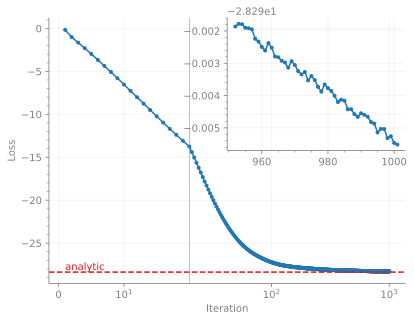

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Iteration', ylabel='Loss'>)

In [9]:
tnopt.plot(hlines={'analytic': qu.heisenberg_energy(L)})

We can check the returned `psi_opt` optimized target indeed matches loss:

In [10]:
loss_fn(psi_opt, ham)

-28.295518668947235

Note this TN (which can be retrieved from [`tnopt.get_tn_opt`](quimb.tensor.optimize.TNOptimizer.get_tn_opt)) is a copy of the original target TN, with the optimized parameters set. It has also been passed through `norm_fn` so is in normalized/projected form, and converted back to `numpy` backed arrays.

## Using tags to opt in, opt out or group tensors

There are three mutually exclusive options when it comes to specifying exactly which tensors to optimize.

1. **Opt in**: specify `tags` that tensors must have to be **optimized**, any tensors without these tags are assumed to be **constant**.
2. **Opt out**: specify a set of `constant_tags` that tensors must have to be **constant**, any tensors without these tags are assumed to be **optimized**.
3. **pytree**: supply an arbitrary pytree of objects to use however within the `norm_fn` and `loss_fn`, in this case all tensors are assumed to be **optimized**.

In all cases you can supply `loss_constants` that are passed to the `loss_fn` but not optimized, this should be a `dict` containing arbitrary pytree values.

In the first case, you can also specify `shared_tags`, which we demonstrate here. Here every tensor with one of shared tags it assumed to share parameters with every other tensor with the same tag. For example, we can create a unit cell of size 2, and specify that our MPS be compsed of two repeated tensors A and B only:

In [11]:
for site in psi.sites:
    t = psi[site]
    if site % 2 == 0:
        t.add_tag("A")
        t.modify(data=psi[0].data)
    else:
        t.add_tag("B")
        t.modify(data=psi[1].data)

psi.normalize()
psi.equalize_norms_()

MatrixProductState(tensors=64, indices=128, L=64, max_bond=16)

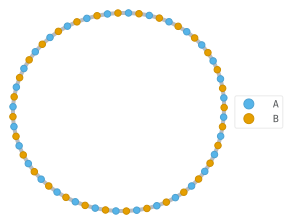

In [12]:
psi.draw(["A", "B"], figsize=(4, 4))

In [13]:
tnopt = qtn.TNOptimizer(
    psi,
    loss_fn=loss_fn,
    norm_fn=norm_fn,
    loss_constants={"ham": ham},
    optimizer="adam",
    autodiff_backend="jax",
    # only optimize the tensors with these tags (in this case all)
    tags=["A", "B"],
    # within those, group all with each of these tags together
    shared_tags=["A", "B"],
)
tnopt

<TNOptimizer(d=1024, backend=jax)>

You can see the dramatic reduction in the number of parameters to optimize, from 32,768 to 1,024. The optimization proceeds in the same way as before, but now the tensors A and B are constrained to be the same.

In [14]:
tnopt.optimize(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

-28.297351837158 [best: -28.297351837158] : : 1001it [00:41, 23.90it/s]                        


MatrixProductState(tensors=64, indices=128, L=64, max_bond=16)

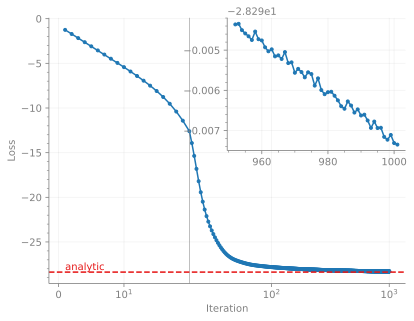

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Iteration', ylabel='Loss'>)

In [15]:
tnopt.plot(hlines={'analytic': qu.heisenberg_energy(L)})

The reduction in parameters also helps the optimization converge faster.

As a sanity check, we can explicitly visualize the first four tensors in the optimized MPS, and see that they do indeed repeat:

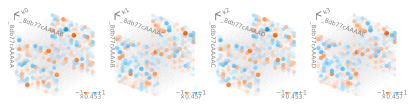

In [16]:
psi_opt = tnopt.get_tn_opt()
psi_opt[:4].visualize_tensors("row")

(optimizing-circuits)=
## Optimizing `Circuit` objects

One special case of optimizing pytrees, is when [`Circuit`](quimb.tensor.circuit.Circuit) objects are encountered. These contain a tensor network representation of the quantum circuit, but only the gates/tensors which have been specified as `parametrized` are optimized.

In [17]:
import autoray as ar

rng = ar.do('random.default_rng', 42, like="numpy")

circ = qtn.Circuit(2)
circ.u3(*rng.uniform(size=3, high=2 * qu.pi), 0, parametrize=True)
circ.u3(*rng.uniform(size=3, high=2 * qu.pi), 1, parametrize=True)
circ.cnot(0, 1)
circ.u3(*rng.uniform(size=3, high=2 * qu.pi), 0, parametrize=True)
circ.u3(*rng.uniform(size=3, high=2 * qu.pi), 1, parametrize=True)

H = qu.ham_heis(2).astype("complex128")

def loss(circ, H):
    en = circ.local_expectation(H, (0, 1), simplify_sequence="ADCRS")
    # we use `autoray.do` to allow arbitrary autodiff backends
    return ar.do("real", en)

tnopt = qtn.TNOptimizer(
    circ,
    loss,
    loss_constants=dict(H=H),
    # because we are using dynamic (entry dependent) simplification
    autodiff_backend="autograd",
)
circ_opt = tnopt.optimize(10)

-0.749999999208 [best: -0.749999999208] : : 13it [00:00, 39.17it/s]                      


The returned circuit now has the optimized parameters set.

In [18]:
circ_opt.gates

(<Gate(label=U3, params=[4.71234134 2.55777369 5.39472984], qubits=(0,), parametrize=True))>,
 <Gate(label=U3, params=[3.14157063 0.52032894 6.13001603], qubits=(1,), parametrize=True))>,
 <Gate(label=CNOT, params=[], qubits=(0, 1))>,
 <Gate(label=U3, params=[4.20005643 5.20517656 0.60518082], qubits=(0,), parametrize=True))>,
 <Gate(label=U3, params=[2.08314126 2.06360383 6.30453863], qubits=(1,), parametrize=True))>)

In [19]:
loss(circ_opt, H)

-0.7499999992075422

But the initial state and constant gates have not been changed, and becuase the parametrized tensors are manifestly unitary, it is always normalized.

```{note}
Note also, that because we used `simplify_sequence="ADCRS"`, which performs TN simplifications that depend on the tensor entries, we cannot use a statically compiled autodiff backend like `jax`. Instead we use an 'eager' library `autograd` here. Another option would be to instead use `simplify_sequence="R"`.
```

If you want fine control over which gates to optimize and share parameters among in the circuit, it is best to extract the TN representation first, and optimize it directly. You can then call [`circ.update_params_from(tn)`](quimb.tensor.circuit.Circuit.update_params_from) to update the circuit parameters from an optimized tensor network.

## Optimizing `PTensor` objects

The circuit object paramterized gates behind the scenes use a 'paramterized' tensor object, [`PTensor`](quimb.tensor.PTensor), which holds a [`PArray`](quimb.tensor.array_ops.PArray). This is a generalization of `Tensor` whose data is defined by a function and some parameters (kind of like a local `norm_fn` that is always applied). You can use these directly for even finer control.

Here we show a very roundabout way of trying to diagonalize a non-symmetric matrix using two orthogonal matrices `U` and `V`.

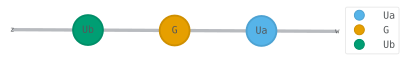

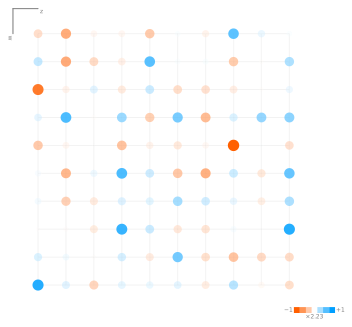

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [20]:
# each parametrized tensor has implicit `data = fn(params)`

Ua = qtn.PTensor(
    # project into isometric / unitary / isometric form
    fn=qtn.decomp.isometrize_cayley,
    # parameters here are some arbitrary array
    params=qu.identity(10, dtype="float64"),
    inds=["w", "x"],
    tags="Ua",
)

G = qtn.Tensor(
    data=qu.randn((10, 10)),
    inds=['x', 'y'],
    tags="G",
)

Ub = qtn.PTensor(
    fn=qtn.decomp.isometrize_cayley,
    params=qu.identity(10, dtype="float64"),
    inds=["y", "z"],
    tags="Ub",
)

(Ua | G | Ub).draw(["Ua", "G", "Ub"])
(Ua | G | Ub).contract().visualize()

In [21]:
def loss(target, G):
    Ua, Ub = target["Ua"], target["Ub"]
    UGU = (Ua | G | Ub).contract(output_inds=['w', 'z']).data
    # minimize off-diagonal elements of UGU
    return ar.do("linalg.norm", UGU - ar.do('diag', ar.do('diag', UGU)))

We'll also here make use of automatic hessian-vector product computation by some backends (e.g. `jax`), which is can be used with second order optimization methods like `Newton-CG`.

In [22]:
tnopt = qtn.TNOptimizer(
    {"Ua": Ua, "Ub": Ub},
    loss,
    loss_constants=dict(G=G),
    optimizer="newton-cg",
    autodiff_backend="jax",
)

In [23]:
to = tnopt.optimize(1000, hessp=True)

+0.000001728355 [best: +0.000001728355] :  60%|██████    | 601/1000 [00:01<00:01, 307.78it/s]


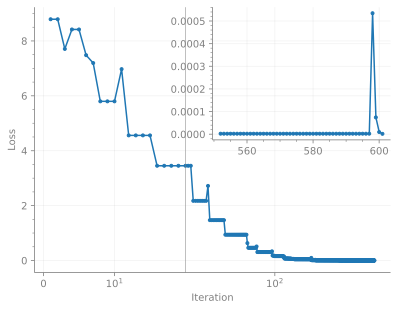

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Iteration', ylabel='Loss'>)

In [24]:
tnopt.plot()

In [25]:
Uao, Ubo = to["Ua"], to["Ub"]
Uao

PTensor(shape=(10, 10), inds=('w', 'x'), tags=oset(['Ua']))

In [26]:
# still orthogonal
Uao.norm()**2, Ubo.norm()**2

(10.000000000000002, 10.000000000000002)

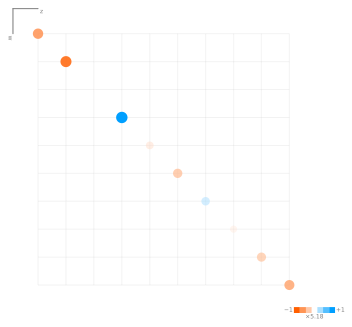

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [27]:
# check gauged G
(Uao | G | Ubo).contract().visualize()